In [ ]:
# @title
!pip -q install brian2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import warnings; warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00


## E1. FHN as a small class

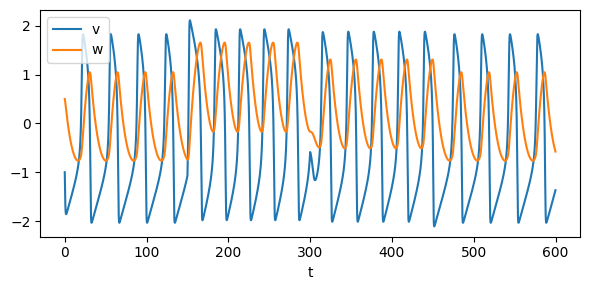

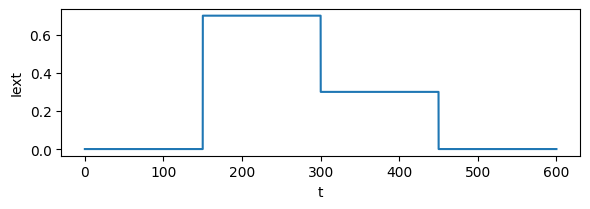

In [ ]:
# @title
from dataclasses import dataclass

@dataclass
class FHNParams:
    a: float = 0.5
    b: float = 0.5
    tau: float = 10.0
    R: float = 1.0

class FHN:
    def __init__(self, p: FHNParams, v0: float=-1.0, w0: float=0.5):
        self.p = p
        self.y0 = np.array([v0, w0], float)

    def slope(self, y, I):
        v, w = y
        dv = v - (v**3)/3.0 - w + self.p.R*I
        dw = (v + self.p.a - self.p.b*w)/self.p.tau
        return np.array([dv, dw])

    def run(self, T=600.0, dt=0.05, I=None):
        n = int(T/dt)
        t = np.arange(n)*dt
        if I is None:
            I = np.zeros(n)
            I[n//4:n//2] = 0.7
            I[n//2:3*n//4] = 0.3
        y = np.zeros((n,2), float)
        y[0] = self.y0
        for i in range(1,n):
            y[i] = y[i-1] + dt*self.slope(y[i-1], I[i-1])
        return t, y[:,0], y[:,1], I

p = FHNParams(); m = FHN(p, v0=-1.0, w0=0.5)
t, v, w, I = m.run()

plt.figure(figsize=(6,3)); plt.plot(t, v, label='v'); plt.plot(t, w, label='w'); plt.xlabel('t'); plt.legend(); plt.tight_layout();
plt.savefig('fig_e1_vw.png', dpi=150); plt.show()
plt.figure(figsize=(6,2.2)); plt.plot(t, I); plt.xlabel('t'); plt.ylabel('Iext'); plt.tight_layout();
plt.savefig('fig_e1_input.png', dpi=150); plt.show()


## E2. FHN in Brian2 (unit-safe)

WARNING    't' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 5.9985e+02, 5.9990e+02,
       5.9995e+02]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([-1.        , -1.05833333, -1.11630572, ..., -1.37607087,
       -1.37284729, -1.36961951]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([ 0.5       ,  0.49625   ,  0.49221771, ..., -0.5719797 ,
       -0.57493011, -0.57785702]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


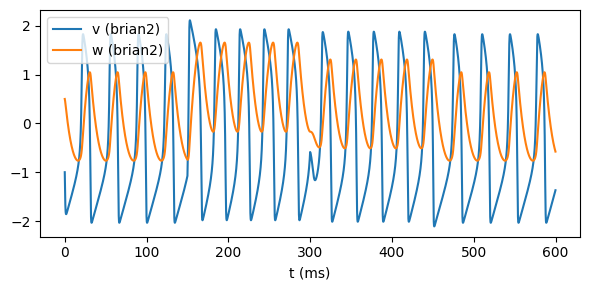

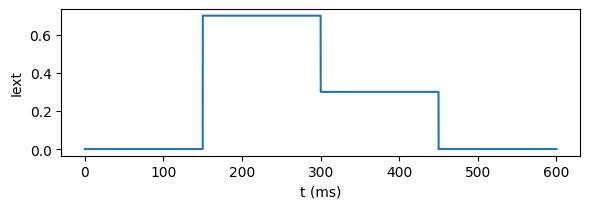

In [ ]:
# @title
import brian2 as b2
b2.start_scope()
b2.defaultclock.dt = 0.05*b2.ms

I_arr = I.copy()
Iext = b2.TimedArray(I_arr, dt=b2.defaultclock.dt)

eqs = '''
dv/dt = (v - (v*v*v)/3 - w + R*i_in) / ms : 1
dw/dt = ((v + a - b*w)/tau) / ms         : 1
i_in = Iext(t) : 1
a : 1
b : 1
tau : 1
R : 1
'''

G = b2.NeuronGroup(1, eqs, method='euler')
G.v = -1.0; G.w = 0.5
G.a = 0.5;  G.b = 0.5
G.tau = 10.0; G.R = 1.0

M = b2.StateMonitor(G, ['v','w','i_in'], record=True)
b2.run(len(I_arr)*b2.defaultclock.dt)

tb = M.t/b2.ms
plt.figure(figsize=(6,3)); plt.plot(tb, M.v[0], label='v (brian2)'); plt.plot(tb, M.w[0], label='w (brian2)'); plt.xlabel('t (ms)'); plt.legend(); plt.tight_layout();
plt.savefig('fig_e2_vw.png', dpi=150); plt.show()
plt.figure(figsize=(6,2.2)); plt.plot(tb, M.i_in[0]); plt.xlabel('t (ms)'); plt.ylabel('Iext'); plt.tight_layout();
plt.savefig('fig_e2_input.png', dpi=150); plt.show()
